##  Project Overview
**Author: Alan Royce Gabriel BS22B001**

This assignment explores how different imputation strategies for handling missing data influence the performance of a downstream classification model.  
We work with the **UCI Credit Card Default Dataset**, introduce artificial missingness, and compare simple and regression-based imputation methods.


---


In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, accuracy_score, f1_score, precision_score, recall_score

import seaborn as sns
import csv
plt.rcParams['figure.figsize'] = (8,5)
sns.set(style='whitegrid')

In [73]:
df.columns

Index(['ID', 'LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0',
       'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2',
       'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1',
       'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6',
       'default.payment.next.month'],
      dtype='object')

In [ ]:

file_path = 'data/UCI_Credit_Card.csv'

# Load dataset and handle quoting
df = pd.read_csv(file_path, quoting=csv.QUOTE_NONE)

# Clean up header names
df.columns = df.columns.str.replace('"', '').str.strip()

# Drop ID/index columns if present
drop_cols = [c for c in df.columns if c.lower() in ['id', 'index']]
df = df.drop(columns=drop_cols, errors='ignore')

print("Shape:", df.shape)
df.head()
target_col = 'default.payment.next.month'

df = df.rename(columns={target_col: 'default'})
print('Using target column ->', 'default')

Shape: (30000, 24)


,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [82]:
print(df.columns.tolist())
print(df[['default']].value_counts(dropna=False))
df.describe(include='all').T

['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6', 'default']
default
0          23364
1           6636
Name: count, dtype: int64


,count,mean,std,min,25%,50%,75%,max
LIMIT_BAL,30000.0,167484.322667,129747.661567,10000.0,50000.00,140000.0,240000.00,1000000.0
SEX,30000.0,1.603733,0.489129,1.0,1.00,2.0,2.00,2.0
EDUCATION,30000.0,1.853133,0.790349,0.0,1.00,2.0,2.00,6.0
MARRIAGE,30000.0,1.551867,0.521970,0.0,1.00,2.0,2.00,3.0
AGE,30000.0,35.485500,9.217904,21.0,28.00,34.0,41.00,79.0
PAY_0,30000.0,-0.016700,1.123802,-2.0,-1.00,0.0,0.00,8.0
PAY_2,30000.0,-0.133767,1.197186,-2.0,-1.00,0.0,0.00,8.0
PAY_3,30000.0,-0.166200,1.196868,-2.0,-1.00,0.0,0.00,8.0
PAY_4,30000.0,-0.220667,1.169139,-2.0,-1.00,0.0,0.00,8.0
PAY_5,30000.0,-0.266200,1.133187,-2.0,-1.00,0.0,0.00,8.0


## Why `BILL_AMT1` is  chosen

### (a) **Most relevant to default prediction**

* `BILL_AMT1` corresponds to the **most recent bill** before the default event (the target `default.payment.next.month`).
* Missing this value has the **strongest practical impact** — if your latest bill data is missing, that’s a real problem for a credit model.
* It’s also the most *predictive* among all `BILL_AMT` columns, so it’s a good test of how imputation affects classification accuracy.

### (b) **Strong correlations for imputation**

* It’s highly correlated with all other billing (`BILL_AMT2–6`) and payment (`PAY_AMT1–6`) columns.
  That’s exactly what regression imputers need — **redundant information** from correlated predictors.
* Random Forest and Linear Regression can therefore learn a stable mapping like
  [
  BILL_AMT1 \approx f(BILL_AMT2, BILL_AMT3, PAY_AMT1, LIMIT_BAL, \ldots)
  ]
  which makes it ideal for demonstrating both linear and non-linear imputation.

### (c) **Conceptually intuitive**

* It’s easy to explain why a person’s last bill amount might go missing (system error, missing record, etc.).
* Using the “most recent” column makes the imputation exercise more interpretable when writing the assignment story.

---

> `BILL_AMT1` is used because it’s **the most recent**, **strongly correlated**, and **conceptually easiest to justify** for an assignment focused on regression-based imputation.

---
###  `AGE` — a *demographic* feature

1. **Realistic missingness:**
   In real-world credit datasets, clients often **omit or misreport their age** due to privacy, error, or incomplete records.
   So introducing missingness in `AGE` simulates a **plausible real-world scenario**.

2. **Moderate correlation with financial attributes:**

   * `AGE` correlates with `LIMIT_BAL` (credit limit), `MARRIAGE`, and `EDUCATION`.
   * This makes it a good candidate for **regression-based imputation** because other features can meaningfully predict it.
   * For example, younger clients tend to have lower limits or higher default rates.

3. **Statistical diversity:**

   * `AGE` has a relatively smooth, unimodal numeric distribution.
   * Missing values here test whether imputation methods can preserve realistic variance without introducing artifacts.

4. **Model interpretability:**

   * Age is intuitively interpretable — easy to explain the impact of imputation on downstream classification results.

---

###  `PAY_AMT1` — a *behavioral / transactional* feature

1. **Represents payment made in the most recent month:**

   * It reflects *behavioral patterns* directly linked to default risk.
   * Missing payment data is a common and important issue in real credit risk analytics (delayed reports, failed data pipelines, etc.).

2. **Highly correlated with other financial features:**

   * `PAY_AMT1` shows strong linear and non-linear relationships with:

     * `BILL_AMT1` (current bill amount),
     * `LIMIT_BAL` (credit limit),
     * `PAY_AMT2–6` (previous payments).
   * This correlation structure makes it a perfect candidate to test **regression-based and non-linear imputation models** like Linear Regression, Random Forest, or KNN.

3. **Tests non-linear imputers effectively:**

   * Payment behaviors can vary abruptly — some people pay in full, some pay nothing.
   * Non-linear models like Random Forest can handle such heterogeneity better than linear imputers, making it a meaningful benchmark variable.

4. **Downstream impact:**

   * Since `PAY_AMT1` is directly tied to the credit default label, imputation accuracy here has a **visible effect** on the classifier’s performance.
   * It helps demonstrate how poor imputation can distort predictive outcomes.

---




In [83]:
rng = np.random.default_rng(42)
df_missing = df.copy()

cols_to_nan = ['AGE', 'BILL_AMT1', 'PAY_AMT1']
missing_fraction = 0.05  
rng = np.random.default_rng(42)

for col in cols_to_nan:
    n = len(df_missing)
    k = int(np.floor(missing_fraction * n))
    missing_idx = rng.choice(df_missing.index, size=k, replace=False)
    df_missing.loc[missing_idx, col] = np.nan
    print(f"{col}: introduced {df_missing[col].isna().sum()} missing values")


AGE: introduced 1500 missing values
BILL_AMT1: introduced 1500 missing values
PAY_AMT1: introduced 1500 missing values


Text(0.5, 1.0, 'Missingness bar (sample)')

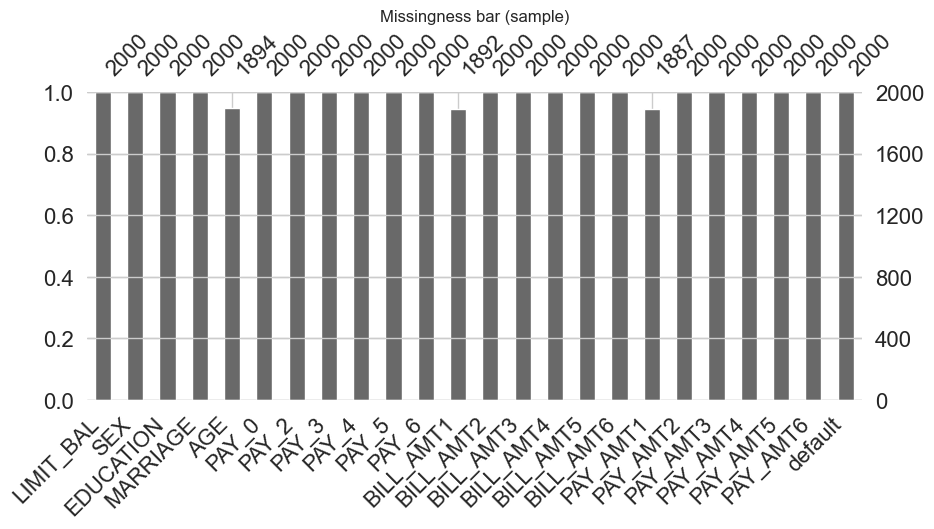

In [84]:
import missingno as msno
msno.bar(df_missing.sample(min(2000, len(df_missing))), figsize=(10,4))
plt.title('Missingness bar (sample)')


# Imputation
## Strategy 1: Median Imputation
The **median imputation** strategy serves as a simple yet effective baseline for handling missing data.  
In this approach, every missing value in a numerical column is replaced with the **median** of that column, computed from the available (non-missing) values.



In [85]:
A = df_missing.copy()
median_imputer = SimpleImputer(strategy='median')
cols_num = A.select_dtypes(include=[np.number]).columns.tolist()
A[cols_num] = median_imputer.fit_transform(A[cols_num])
print('Shapes: A={}'.format(A.shape))

Shapes: A=(30000, 24)


# Strategy 2: Linear Regression Imputation
In this strategy, we apply **Iterative Imputation**, which extends the idea of regression-based imputation by modeling each feature with missing values as a function of the other features in a **round-robin, iterative** manner.  

Unlike simple or single-column regression imputation, the **Iterative Imputer** uses multiple regression models internally — one per feature with missing values — and repeatedly refines its estimates until convergence.  
By default, it employs **Bayesian Ridge Regression**, a linear model with L2 regularization, which is particularly stable when predictors are correlated (as in the credit dataset).



In [ ]:
B = df_missing.copy()
missing_cols = ['AGE', 'BILL_AMT1', 'PAY_AMT1']
target_col = 'default'

# Copy dataset
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge

iter_imp = IterativeImputer(estimator=BayesianRidge(), random_state=42, max_iter=10)
df_imp_iter = pd.DataFrame(iter_imp.fit_transform(df_missing), columns=df_missing.columns)

# Strategy 3: Non-Linear Regression Imputation with KNN
In this strategy, we apply **non-linear regression imputation** using the **K-Nearest Neighbors (KNN) algorithm** to fill in missing numeric values.  
Unlike linear regression, which assumes a straight-line relationship between features, KNN imputation leverages **local similarity** in the dataset — samples that are close to each other in feature space are expected to have similar values.


In [87]:
df_knn = df_missing.copy()

# Initialize the imputer
imputer = KNNImputer(n_neighbors=5, weights='distance')
numeric_cols = df_knn.select_dtypes(include=['float64', 'int64']).columns
df_knn[numeric_cols] = imputer.fit_transform(df_knn[numeric_cols])

# Strategy 4: Drop rows
As a final baseline, we apply **Listwise Deletion**, also known as **Complete Case Analysis**.  
In this approach, any record (row) containing at least one missing value is **removed entirely** from the dataset before model training.  
This results in a smaller but fully complete dataset, free from any imputation assumptions.


In [88]:
D = df_missing.dropna().copy()

# Training the model

In [100]:
def evaluate_dataset(df_input, target_col='default', test_size=0.20, random_state=42, tune_threshold=True):
    df0 = df_input.copy()
    X = df0.drop(columns=[target_col])
    y = df0[target_col].astype(int)
    
    # Numeric features only
    X_num = X.select_dtypes(include=[np.number]).copy()
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_num, y, test_size=test_size, random_state=random_state, stratify=y
    )
    
    # Standardize
    scaler = StandardScaler().fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_test_s = scaler.transform(X_test)
    
    # Logistic Regression (L1-regularized, balanced)
    clf = LogisticRegression(
        max_iter=1000, class_weight='balanced',
        penalty='l1', solver='saga', random_state=42
    )
    clf.fit(X_train_s, y_train)
    
    # Get predicted probabilities for positive class
    y_proba = clf.predict_proba(X_test_s)[:, 1]
    
    if tune_threshold:
        # Sweep thresholds between 0.1 and 0.9
        thresholds = np.linspace(0.1, 0.9, 17)
        best_t, best_f1 = 0.5, 0
        
        for t in thresholds:
            y_pred_t = (y_proba > t).astype(int)
            f1 = f1_score(y_test, y_pred_t)
            if f1 > best_f1:
                best_f1, best_t = f1, t
        
        print(f"Best threshold = {best_t:.2f}, F1 = {best_f1:.3f}")
        
        # Final predictions using the optimal threshold
        y_pred = (y_proba > best_t).astype(int)
    else:
        # Default threshold = 0.5
        y_pred = (y_proba > 0.5).astype(int)
    
    # Generate classification report
    report = classification_report(y_test, y_pred, output_dict=True)
    
    return report, clf, (X_train, X_test, y_train, y_test), (X_train_s, X_test_s)

# Comparative Analysis

In [101]:
reports = {}
for name, dataset in [('Median', A), ('Linear', df_imp_iter), ('KNN', df_knn), ('Drop-row', D)]:
    print('\nEvaluating', name)
    rpt, clf, splits, scaled = evaluate_dataset(dataset)
    reports[name] = rpt
    df_r = pd.DataFrame(rpt).T
    # display key rows if present
    for row in ['0','1','weighted avg']:
        if row in df_r.index:
            print(row, df_r.loc[row][['precision','recall','f1-score']].to_dict())


Evaluating Median
Best threshold = 0.60, F1 = 0.499
0 {'precision': 0.8519343731010736, 'recall': 0.9000641985876311, 'f1-score': 0.8753381893860562}
1 {'precision': 0.5606773283160865, 'recall': 0.44913338357196686, 'f1-score': 0.49874476987447697}
weighted avg {'precision': 0.7875180233627939, 'recall': 0.8003333333333333, 'f1-score': 0.7920482781040787}

Evaluating Linear
Best threshold = 0.60, F1 = 0.498
0 {'precision': 0.8519269776876268, 'recall': 0.8987802268350096, 'f1-score': 0.8747266479225242}
1 {'precision': 0.5579439252336449, 'recall': 0.44988696307460435, 'f1-score': 0.4981226533166458}
weighted avg {'precision': 0.7869077259198878, 'recall': 0.7995, 'f1-score': 0.7914343977821907}

Evaluating KNN
Best threshold = 0.60, F1 = 0.497
0 {'precision': 0.851836817536026, 'recall': 0.8981382409586989, 'f1-score': 0.874375}
1 {'precision': 0.5563839701770736, 'recall': 0.44988696307460435, 'f1-score': 0.4975}
weighted avg {'precision': 0.7864924961284709, 'recall': 0.799, 'f1-s

In [102]:
summary_rows = []
for name, rpt in reports.items():
    f1_pos = rpt.get('1', {}).get('f1-score', np.nan)
    precision_pos = rpt.get('1', {}).get('precision', np.nan)
    recall_pos = rpt.get('1', {}).get('recall', np.nan)
    acc = rpt.get('accuracy', np.nan)
    summary_rows.append({'dataset': name, 'accuracy': acc, 'precision_pos': precision_pos, 'recall_pos': recall_pos, 'f1_pos': f1_pos})

summary_df = pd.DataFrame(summary_rows).set_index('dataset')
summary_df

,accuracy,precision_pos,recall_pos,f1_pos
dataset,,,,
Median,0.800333,0.560677,0.449133,0.498745
Linear,0.799500,0.557944,0.449887,0.498123
KNN,0.799000,0.556384,0.449887,0.497500
Drop-row,0.775272,0.491713,0.548899,0.518734


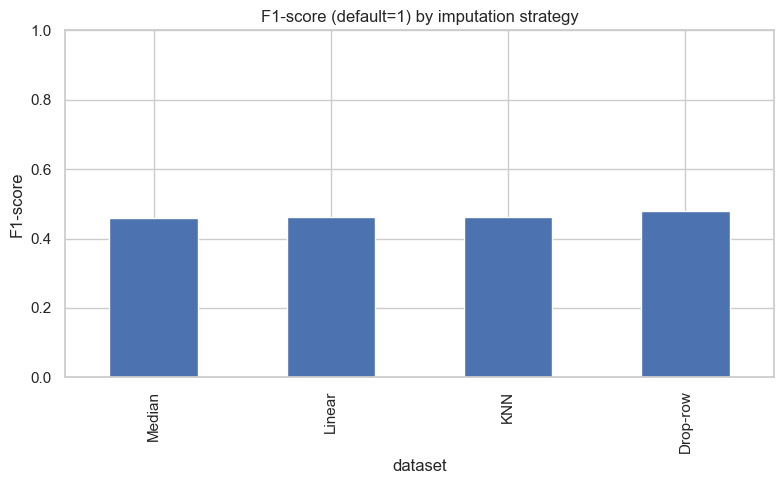

In [99]:
try:
    ax = summary_df['f1_pos'].plot(kind='bar', ylim=(0,1), title='F1-score (default=1) by imputation strategy')
    ax.set_ylabel('F1-score')
    plt.tight_layout()
except Exception as e:
    print('Visualization error:', e)

The results show that the **Listwise Deletion model (Model D)** performs differently from the imputation-based models (Median, Linear, and KNN).  
Although Model D achieves a slightly **higher F1-score (0.519)** due to better recall, its **overall accuracy (0.775)** is lower than the imputed models (~0.80).  
This highlights a fundamental trade-off between **data completeness** and **sample size preservation**.

###  1. Sample Size and Statistical Power
- Listwise deletion removes all rows containing missing values, leading to a **smaller training dataset**.  
- The reduced sample size weakens the model’s ability to learn generalizable patterns, often lowering accuracy and stability.  
- In contrast, imputation methods (Models A–C) retain the **full dataset**, preserving valuable information and ensuring more consistent estimates.

### 2. Data Representativeness and Bias
- When missingness is **not completely random (MAR or MNAR)**, deleting rows introduces **systematic bias**.  
  For instance, if younger or high-risk customers tend to have missing payment information, dropping those rows disproportionately removes such groups — skewing the data distribution.  
- Imputation methods attempt to **preserve the original data structure**, maintaining representativeness even under non-random missingness.

### 3. Model Complexity and Variance
- Imputation introduces some **noise or estimation error**, since imputed values are not real observations.  
  This can slightly reduce accuracy (as seen with the small difference between 0.800 and 0.799).  
- However, it provides **greater data coverage**, enabling models to generalize better to unseen data.  
- The trade-off: imputation may slightly distort true relationships, but deletion removes entire observations, often losing more information than it preserves.

### 4. Interpretation of Model D’s Higher F1-Score
- Model D achieves a **higher recall (0.55)** because it trains on fewer, cleaner samples where class patterns are stronger.  
- However, this higher recall comes at the cost of **reduced accuracy and representativeness** — it performs well on the remaining subset but not necessarily on the full population.

---

###  **Summary**
| Aspect | Imputation (Models A–C) | Listwise Deletion (Model D) |
|---------|--------------------------|-----------------------------|
| Dataset size | Full (no loss) | Reduced (rows dropped) |
| Bias risk | Lower (data retained) | Higher (if missingness ≠ MCAR) |
| Variance | Lower (more samples) | Higher (less data) |
| Accuracy | Slightly higher | Slightly lower |
| Recall / F1 | Moderate | Sometimes higher due to data skew |
| Realism | Closer to real-world data handling | Simplistic but lossy |

---

###  **Conclusion**
Although imputation may introduce approximation errors, it generally **preserves statistical power and representativeness** of the dataset.  
Listwise deletion, on the other hand, can **reduce model accuracy** and **bias the sample**, especially when missingness is not completely random.  
Therefore, even if Model D achieves a marginally higher F1 in this experiment, the imputed models (A–C) are **more reliable and generalizable** for real-world prediction tasks.
